<a href="https://colab.research.google.com/github/subpic/koniq/blob/master/koncept512_train_test_py3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install and load libraries

In [0]:
%%capture

# Setup paths
drive_mount = '/content/drive/'
drive_root = drive_mount + 'My Drive/research/data/'  # persistent storage for dataset images
data_root = '/content/koniq/'                         # library install path

!git clone https://github.com/subpic/ku.git
!git clone https://github.com/subpic/koniq.git
!pip install munch

%tensorflow_version 1.x
from ku import model_helper as mh
from ku import applications as apps
from ku import tensor_ops as ops
from ku import generic as gen
from ku import image_utils as iu

import pandas as pd, numpy as np, os
from matplotlib import pyplot as plt
from munch import Munch

from google.colab import drive
drive.mount(drive_mount)

### Setup KonIQ-10k dataset images
Download images resized to 512x384 pixels (originals are 1024x768)

In [0]:
%%capture
gen.make_dirs(drive_root+'koniq/')
drive_image_path = drive_root+'koniq/koniq10k_512x384.zip'
if not os.path.exists(drive_image_path):
  !wget -O "$drive_image_path" "http://datasets.vqa.mmsp-kn.de/archives/koniq10k_512x384.zip"

gen.make_dirs(data_root+'images/')
data_images_path = data_root+'images/'
!cp  "$drive_image_path" "$data_images_path"
%cd $data_images_path
!unzip -o koniq10k_512x384.zip
%cd $data_root

### Define the KonCept512 model

In [0]:
ids = pd.read_csv(data_root + 'metadata/koniq10k_distributions_sets.csv')

from keras.models import Model

# Build scoring model
base_model, preprocess_fn = apps.get_model_imagenet(apps.InceptionResNetV2)
head = apps.fc_layers(base_model.output, name='fc', 
                      fc_sizes      = [2048, 1024, 256, 1], 
                      dropout_rates = [0.25, 0.25, 0.5, 0], 
                      batch_norm    = 2)    

model = Model(inputs = base_model.input, outputs = head)

# Parameters of the generator
pre = lambda im: preprocess_fn(
         iu.ImageAugmenter(im, remap=False).fliplr().result)
gen_params = dict(batch_size  = 16,
                  data_path   = data_root+'images/512x384/',
                  process_fn  = pre, 
                  input_shape = (384,512,3),
                  inputs      = ['image_name'],
                  outputs     = ['MOS'])

# Wrapper for the model, helps with training and testing
helper = mh.ModelHelper(model, 'KonCept512', ids, 
                     loss='MSE', metrics=["MAE", ops.plcc_tf],
                     monitor_metric = 'val_loss', 
                     monitor_mode   = 'min', 
                     multiproc   = True, workers = 5,
                     logs_root   = drive_root + 'logs/koniq',
                     models_root = drive_root + 'models/koniq',
                     gen_params  = gen_params)

### Train it

In [0]:
# do validation in memory
valid_gen = helper.make_generator(ids[ids.set=='validation'], 
                                  batch_size = len(ids[ids.set=='validation']))
valid_data = valid_gen[0]

helper.train(valid_gen=valid_data, lr=1e-4, epochs=40)
helper.load_model()
helper.train(valid_gen=valid_data, lr=1e-4/5, epochs=20)

### Load trained model

In [0]:
%%capture
# download the pre-trained KonCept512 model
model_root = data_root + 'models/'
gen.make_dirs(model_root)
!wget -O "{model_root}koncep512-model.h5" "http://datasets.vqa.mmsp-kn.de/archives/koncep512-trained-model.h5"
helper.model.load_weights(model_root + 'koncep512-model.h5')

### Test model on the default test set

SRCC: 0.919 | PLCC: 0.932 | MAE: 9.132 | RMSE: 10.233


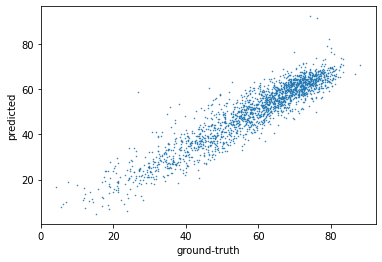

In [13]:
y_pred = helper.predict()
y_true = ids[ids.set=='test'].MOS.values
apps.rating_metrics(y_true, y_pred);

### Predict on a custom image (example)

In [14]:
# Load an image
image_path = data_root + 'images/512x384/' + ids.image_name.values[0]
im = preprocess_fn(iu.read_image(image_path))

# Create a batch, of 1 image
batch = np.expand_dims(im, 0)

# Predict quality score
y_pred = helper.model.predict(batch).squeeze()
print(f'Predicted score: {y_pred:.{2}f}, ground-truth score: {ids.MOS.values[0]:.{2}f}')

Predicted score: 68.33, ground-truth score: 77.38
